In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/test'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks_png')]

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/00087a6bd4dc_01.jpg'),
 PosixPath('data/carvana/train/00087a6bd4dc_02.jpg'),
 PosixPath('data/carvana/train/00087a6bd4dc_03.jpg'),
 PosixPath('data/carvana/train/00087a6bd4dc_04.jpg'),
 PosixPath('data/carvana/train/00087a6bd4dc_05.jpg')]

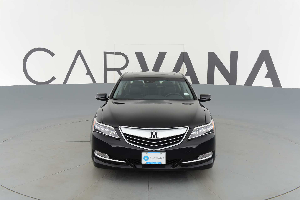

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/00087a6bd4dc_01_mask.gif'),
 PosixPath('data/carvana/train_masks/00087a6bd4dc_02_mask.gif'),
 PosixPath('data/carvana/train_masks/00087a6bd4dc_03_mask.gif'),
 PosixPath('data/carvana/train_masks/00087a6bd4dc_04_mask.gif'),
 PosixPath('data/carvana/train_masks/00087a6bd4dc_05_mask.gif')]

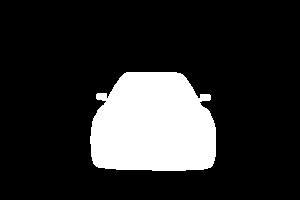

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

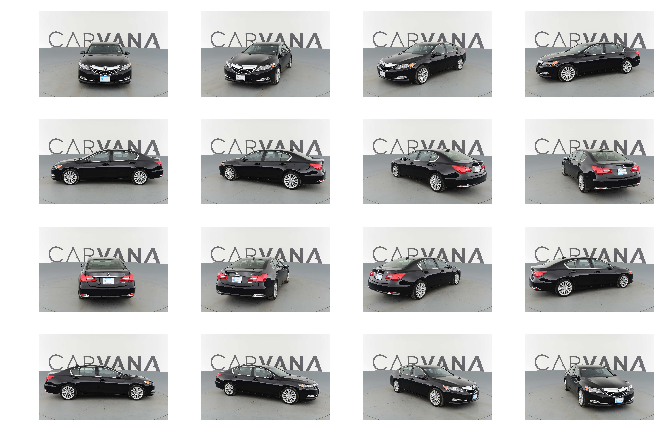

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [15]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [16]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [17]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(16) as e: e.map(convert_img, files)

In [18]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [19]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(16) as e: e.map(resize_mask, files)

In [20]:
(PATH/'train-128').mkdir(exist_ok=True)

In [21]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(16) as e: e.map(resize_img, files)

## Dataset

In [22]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [23]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

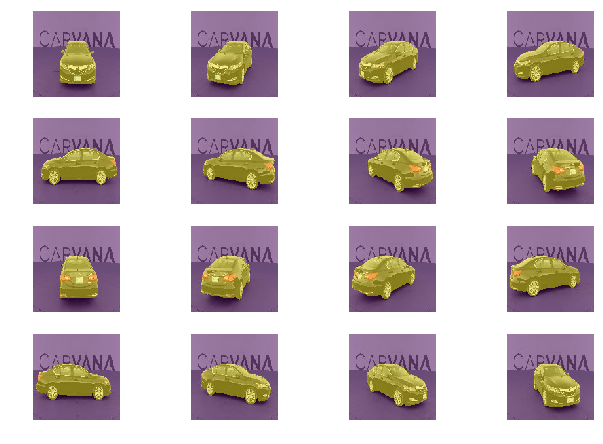

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [25]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [26]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [27]:
len(x_names)//16//5*16

1008

In [28]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [29]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [30]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [31]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

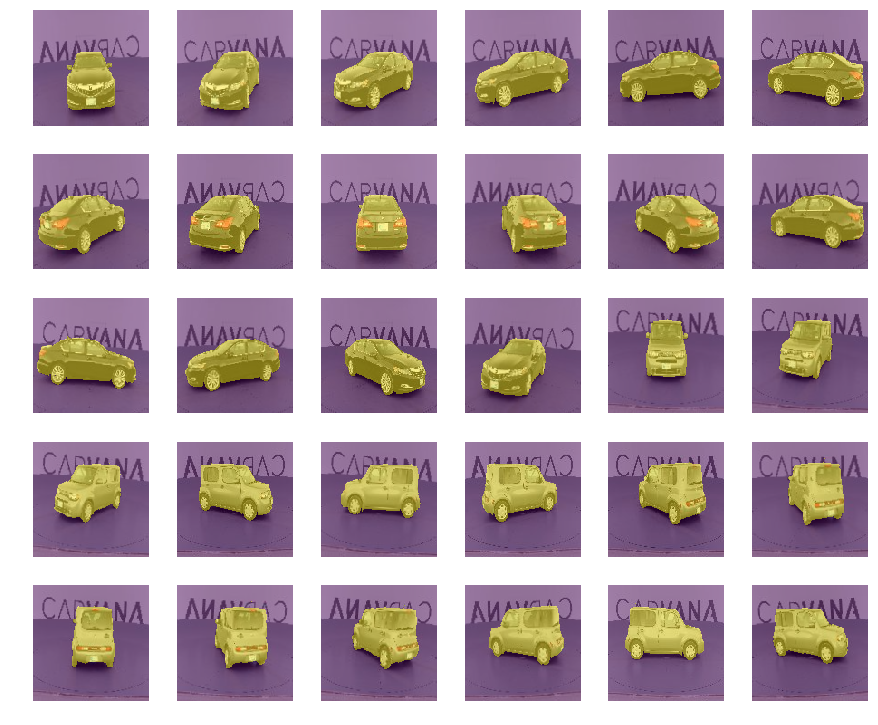

In [32]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [33]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [34]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [35]:
flatten_channel = Lambda(lambda x: x[:,0])

In [43]:
class StdResLayer(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Conv2d(nin, nin, 3, stride=1, padding=1),
            nn.BatchNorm2d(nin),           
            nn.ReLU(),
            nn.Conv2d(nin, nin, 3, stride=1, padding=1),
            nn.BatchNorm2d(nout),           
            nn.ReLU()
        )
        
    def forward(self, x): 
        return x + self.sequence(x)

In [44]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdResLayer(512,512),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [45]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

 89%|████████▉ | 57/64 [00:04<00:00, 12.85it/s, loss=1.57] 


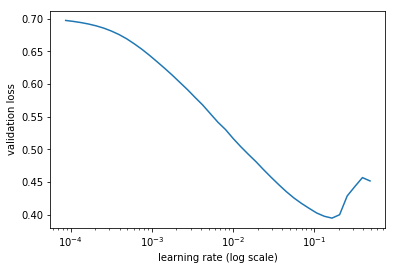

In [46]:
learn.lr_find()
learn.sched.plot()

In [47]:
lr=4e-2

In [48]:
learn.fit(lr,1,cycle_len=5,use_clr_beta=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.136841   0.111083   0.960602  
    1      0.089465   0.076531   0.967295                   
    2      0.070999   0.070057   0.96799                    
    3      0.060908   0.058882   0.975293                   
    4      0.052255   0.05394    0.976593                   



[array([0.05394]), 0.9765927148243737]

In [49]:
learn.save('tmp')

In [50]:
learn.load('tmp')

In [51]:
py,ay = learn.predict_with_targs()

In [52]:
ay.shape

(1008, 128, 128)

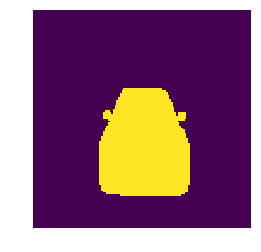

In [53]:
show_img(ay[0]);

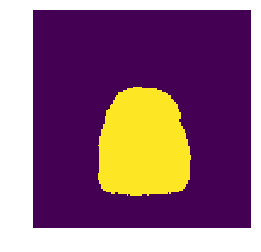

In [54]:
show_img(py[0]>0);

In [55]:
learn.unfreeze()

In [56]:
learn.bn_freeze(True)

In [57]:
lrs = np.array([lr/100,lr/10,lr])/4

In [58]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.055068   0.046455   0.979054  
    1      0.046273   0.042564   0.980182                   
    2      0.071501   0.065555   0.967739                   
    3      0.049071   0.037279   0.983676                   
    4      0.037223   0.032312   0.986261                   
    5      0.031456   0.029856   0.988047                   
    6      0.028431   0.027912   0.988008                   
    7      0.026199   0.027196   0.9882                     
    8      0.02577    0.026106   0.989367                   
    9      0.024102   0.025094   0.989046                   
    10     0.023115   0.02434    0.989953                   
    11     0.022163   0.023609   0.990125                   
    12     0.021488   0.023325   0.990569                   
    13     0.020875   0.022854   0.990789                   
    14     0.020351   0.022795   0.990393                   
    15     0.019829   0.022133   0.990725

[array([0.02102]), 0.991507091219463]

In [59]:
learn.save('0')

In [60]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [61]:
py[0].shape

(128, 128)

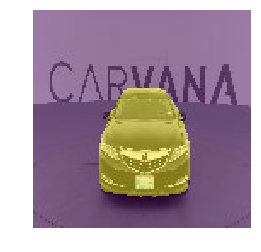

In [62]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

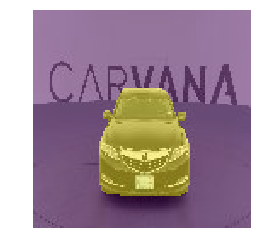

In [63]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 512x512

In [64]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [65]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [66]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [67]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [68]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [69]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [70]:
learn.load('0')

 66%|██████▋   | 169/255 [02:23<01:13,  1.17it/s, loss=0.578]

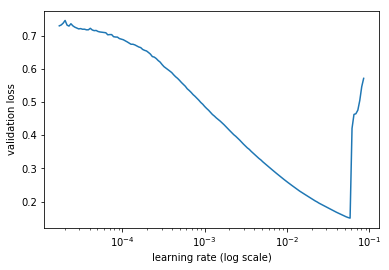

In [73]:
learn.lr_find()
learn.sched.plot(n_skip_end=0)

In [74]:
lr=1e-2

In [75]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.028638   0.023241   0.99146   
    1      0.017025   0.016757   0.993218                     
  6%|▋         | 16/255 [00:14<03:41,  1.08it/s, loss=0.0168]

KeyboardInterrupt: 

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024

In [ ]:
sz = 1024
bs = 4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel,
)

In [ ]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [ ]:
learn.load('512')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/8

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## Fin